#### Hierarchical classifiers - tier 2

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

In [3]:
with open("x_training.pkl" , "rb") as file:
    x_training = pk.load(file)
with open("y_training.pkl" , "rb") as file:
    y_training = pk.load(file)

In [4]:
# transform class 2 in class 1
y_training_first = np.where(y_training <= 1 , y_training , 1)

# checks
print(len(y_training) , len(y_training_first))
print(np.unique(y_training_first))

202945 202945
[0. 1.]


#### Strategy to select second classifier:

I will now use LogisticRegression and HisGradientBoosting to predict healthy and disease.  
All entries classified as disease will form a new dataset, that will be used to train the second classifier.  
Second classifier will be chosen among LogisticRegression , HistGradientBoosting and BalancedRandomForest.  
The aim is to create a second classifier able to distinguish between healthy, prediabetics and diabetics, hoping that the noise removed in the first classification will allow the second classifier to form better predictions.  

In [5]:
# tier 1 models:

logistic_reg = Pipeline([
('scaler', StandardScaler()), 
('lgr', LogisticRegression(
solver="lbfgs", 
max_iter=500, 
class_weight="balanced"
))
])

boolean_mask = [False if col == "BMI" or col == "MentHlth" or col == "PhysHlth" else True for col in x_training.columns]
hgbc = HistGradientBoostingClassifier(
random_state = 42,
class_weight="balanced",
max_iter=500,
categorical_features=boolean_mask
)

models = { "LogisticRegression" : logistic_reg , "HistogramGradientBoosting" : hgbc}

#### 1. Dataset creation
to create the dataset for the second model without throwing away half of the data, I will train the tier 1 model using cross validation and use out-of-fold predictions to create the new dataset.

In [6]:
datasets = {}

for name , model in models.items():
    
    probs_cv = cross_val_predict(
        model, 
        x_training, 
        y_training_first, 
        cv=5, 
        method='predict_proba',
        n_jobs=-1
    )[:, 1]
    
    # create mask to mark dataset 2
    mask = probs_cv >= 0.2
    
    # create dataset 2
    datasets[f"{name}"] = x_training[mask] , y_training[mask]

In [7]:
datasets.keys()

dict_keys(['LogisticRegression', 'HistogramGradientBoosting'])

#### 2. New model testing (LogisticRegression tier1)
I will now add the BalancedRandomForest in the new cohort of models.  
I will then test each model's ability to predict on the new datasets

In [8]:
# add the balanced random forest

bal_rfc = BalancedRandomForestClassifier(
    n_estimators = 500,
    replacement=False,
    random_state=42,
    n_jobs=-1    
)

models["BalancedRandomForest"] = bal_rfc

CLASSIFICATION REPORT LogisticRegression:

              precision    recall  f1-score   support

     Healthy       0.89      0.63      0.74     21577
    Pre-diab       0.03      0.23      0.06       681
        Diab       0.38      0.56      0.45      5498

    accuracy                           0.61     27756
   macro avg       0.44      0.47      0.42     27756
weighted avg       0.77      0.61      0.66     27756

MCC LogisticRegression:  0.25532554015934644


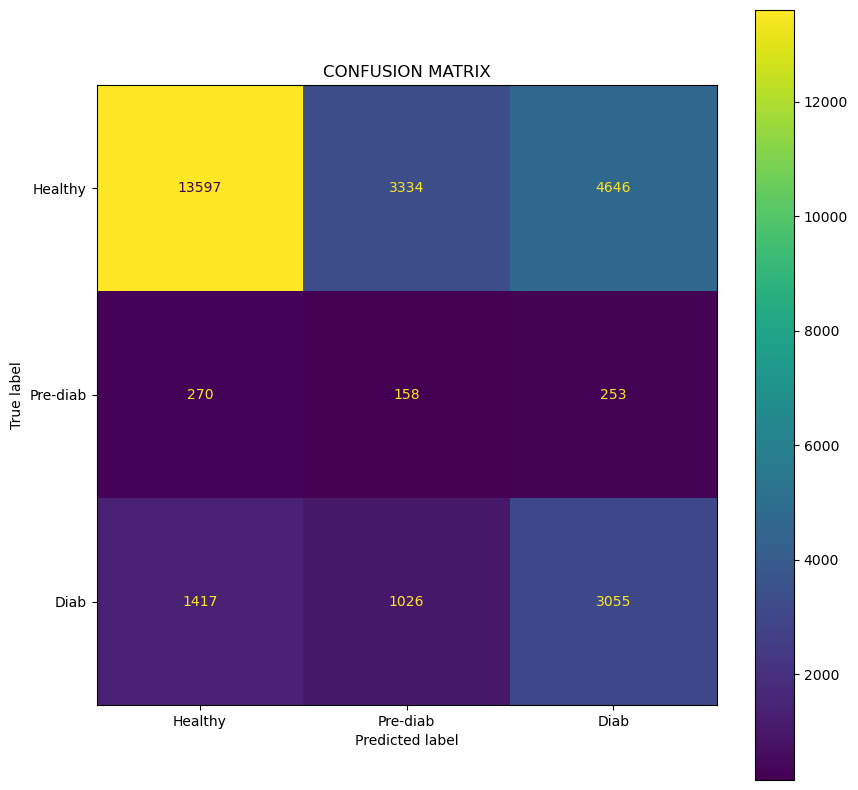

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT HistogramGradientBoosting:

              precision    recall  f1-score   support

     Healthy       0.89      0.63      0.74     21577
    Pre-diab       0.03      0.21      0.06       681
        Diab       0.38      0.57      0.46      5498

    accuracy                           0.61     27756
   macro avg       0.44      0.47      0.42     27756
weighted avg       0.77      0.61      0.66     27756

MCC HistogramGradientBoosting:  0.25823704240656964


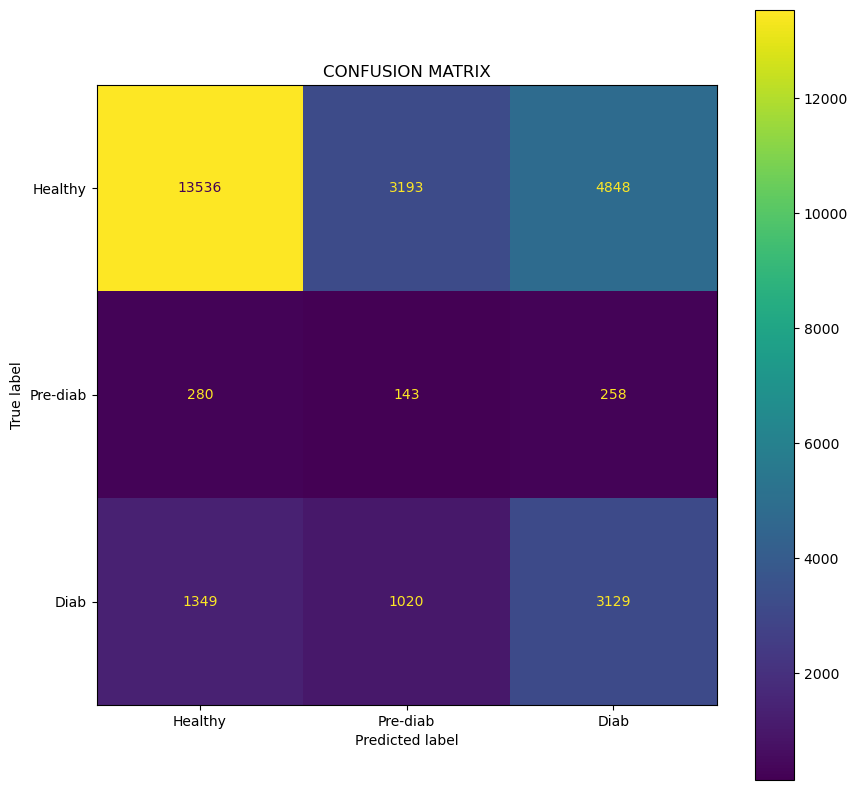

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT BalancedRandomForest:

              precision    recall  f1-score   support

     Healthy       0.89      0.55      0.68     21577
    Pre-diab       0.03      0.33      0.06       681
        Diab       0.38      0.51      0.44      5498

    accuracy                           0.54     27756
   macro avg       0.44      0.46      0.39     27756
weighted avg       0.77      0.54      0.62     27756

MCC BalancedRandomForest:  0.22430293633064005


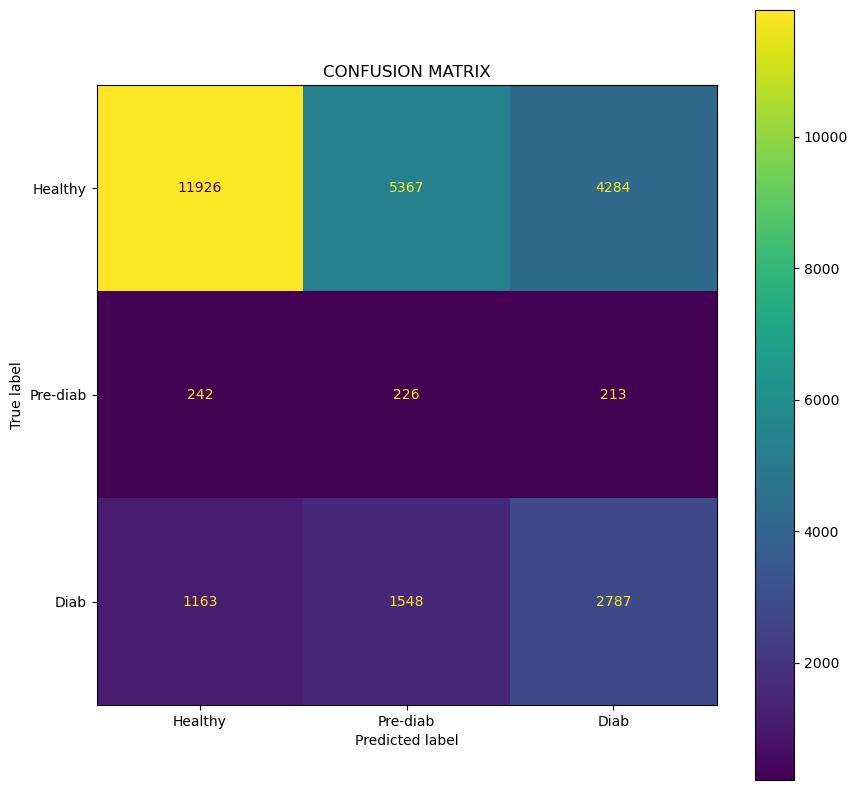

--------------------------------------------------------------------------------------------------------------------------




In [9]:
# train and predict (before threshold tuning) Lets start with the LogisticRegression dataset

# iterate on models and show confusion matrix
# create splits
x_train2 , x_test2 , y_train2 , y_test2 = train_test_split( datasets["LogisticRegression"][0] , datasets["LogisticRegression"][1],
                                                            test_size=0.2 , stratify=datasets["LogisticRegression"][1] , random_state=42)

for name , model in models.items():

    model.fit(x_train2 , y_train2)
    y_pred = model.predict(x_test2)
    
    print(f"CLASSIFICATION REPORT {name}:\n")
    print(classification_report(y_test2, y_pred, target_names=['Healthy', 'Pre-diab', 'Diab']))
    print(f"MCC {name}:  {matthews_corrcoef(y_test2 , y_pred)}")
    
    cm = confusion_matrix(y_test2, y_pred, labels=[0, 1, 2])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Pre-diab', 'Diab'])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', ax=ax, values_format='d') 
    plt.title("CONFUSION MATRIX")
    plt.show()
    
    print("--------------------------------------------------------------------------------------------------------------------------")
    print("\n")

#### Results: threshold tuning is still necessary
Balanced random forest misclassified fewer pre-diabetics as healthy, but predicted as prediabetics 2000 more healthy people compared to the other 2 models. 

#### 3. Threshold tuning (LogisticRegression tier 1)

In [21]:
thresholds = np.arange(0.1, 0.75, 0.05) # from 0.1 to 0.75 

for name, model in models.items():
    print(f"\n{'='*30} {name} {'='*30}")
    
    # training
    model.fit(x_train2, y_train2)
    
    # obtain probabilities

    probs_matrix = model.predict_proba(x_test2)
    prob_pre = probs_matrix[:, 1]
    prob_dia = probs_matrix[:, 2]

    print(f"{'Model ':<20} | {'THR Diab':<8} | {'THR Pre':<8} || {'REC Diab (2)':<12} | {'REC Pre (1)':<12} | {'SPEC Healthy (0)':<16}")
    print("-" * 105)

    #double loop to iterate over prediabetic and diabetic thresholds
    
    for t_dia in thresholds:
        for t_pre in thresholds:

            # create a 0 vector
            preds_final = np.zeros(len(y_test2))

            # prioritize diabetics
            mask_dia = prob_dia >= t_dia
            preds_final[mask_dia] = 2
            
            mask_pre = (~mask_dia) & (prob_pre >= t_pre)
            preds_final[mask_pre] = 1
            
            
            # compute metrics
            df_res = pd.DataFrame({'Real': y_test2, 'Pred': preds_final})
            
            # Recall diabetics
            rec_dia = df_res[df_res['Real'] == 2]['Pred'].apply(lambda x: 1 if x==2 else 0).mean()
            
            # Recall prediabetics
            rec_pre = df_res[df_res['Real'] == 1]['Pred'].apply(lambda x: 1 if x==1 else 0).mean()
            
            # Specifity healthy
            spec_healthy = df_res[df_res['Real'] == 0]['Pred'].apply(lambda x: 1 if x==0 else 0).mean()
            
            marker = " <---" if (rec_dia > 0.80 and rec_pre > 0.80) else ""
            
            print(f"{name:<20} | {t_dia:.2f}     | {t_pre:.2f}     || {rec_dia:.4f}       | {rec_pre:.4f}       | {spec_healthy:.4f}{marker}")

    print("-" * 105)


============================== LogisticRegression ==============================
Model                | THR Diab | THR Pre  || REC Diab (2) | REC Pre (1)  | SPEC Healthy (0)
---------------------------------------------------------------------------------------------------------
LogisticRegression   | 0.10     | 0.10     || 0.9983       | 0.0030       | 0.0000
LogisticRegression   | 0.10     | 0.15     || 0.9983       | 0.0030       | 0.0000
LogisticRegression   | 0.10     | 0.20     || 0.9983       | 0.0030       | 0.0009
LogisticRegression   | 0.10     | 0.25     || 0.9983       | 0.0015       | 0.0035
LogisticRegression   | 0.10     | 0.30     || 0.9983       | 0.0015       | 0.0083
LogisticRegression   | 0.10     | 0.35     || 0.9983       | 0.0015       | 0.0110
LogisticRegression   | 0.10     | 0.40     || 0.9983       | 0.0000       | 0.0122
LogisticRegression   | 0.10     | 0.45     || 0.9983       | 0.0000       | 0.0126
LogisticRegression   | 0.10     | 0.50     || 0.9983   

#### Results:
They are not great. Models are all very similar, and they cannot distinguish healthy against prediabetic and diabetic even after the tier1 classification.  

#### 4. New model testing (HistogramGradientBoosting tier1):

CLASSIFICATION REPORT LogisticRegression:

              precision    recall  f1-score   support

     Healthy       0.88      0.62      0.73     20240
    Pre-diab       0.03      0.21      0.05       667
        Diab       0.38      0.54      0.45      5450

    accuracy                           0.59     26357
   macro avg       0.43      0.46      0.41     26357
weighted avg       0.76      0.59      0.65     26357

MCC LogisticRegression:  0.24247784492761867


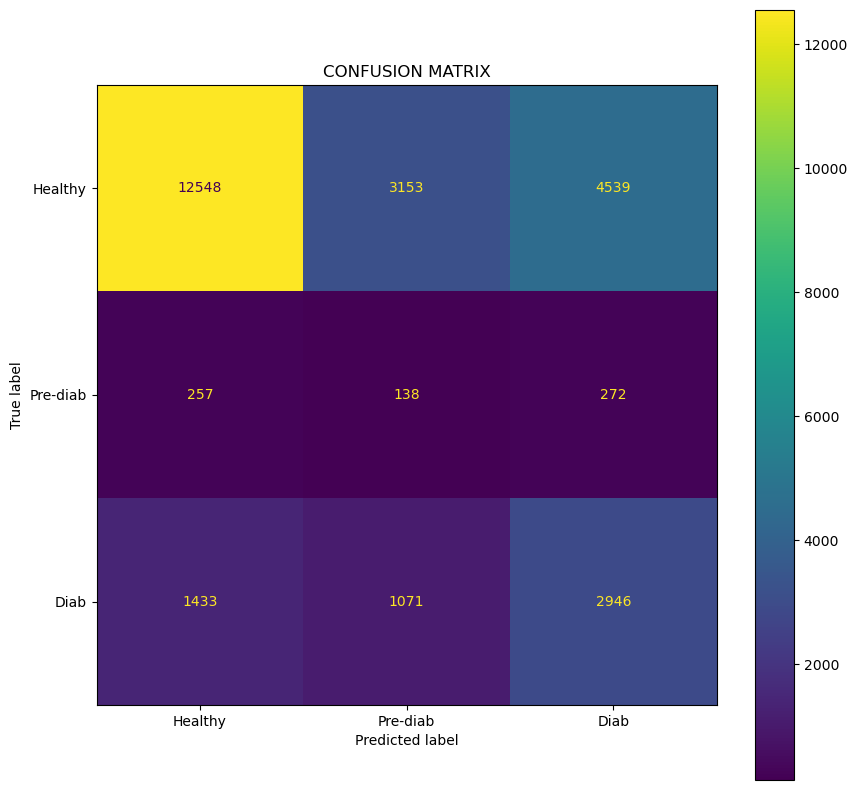

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT HistogramGradientBoosting:

              precision    recall  f1-score   support

     Healthy       0.88      0.62      0.73     20240
    Pre-diab       0.03      0.21      0.06       667
        Diab       0.38      0.56      0.46      5450

    accuracy                           0.60     26357
   macro avg       0.43      0.46      0.41     26357
weighted avg       0.76      0.60      0.66     26357

MCC HistogramGradientBoosting:  0.2499921932922473


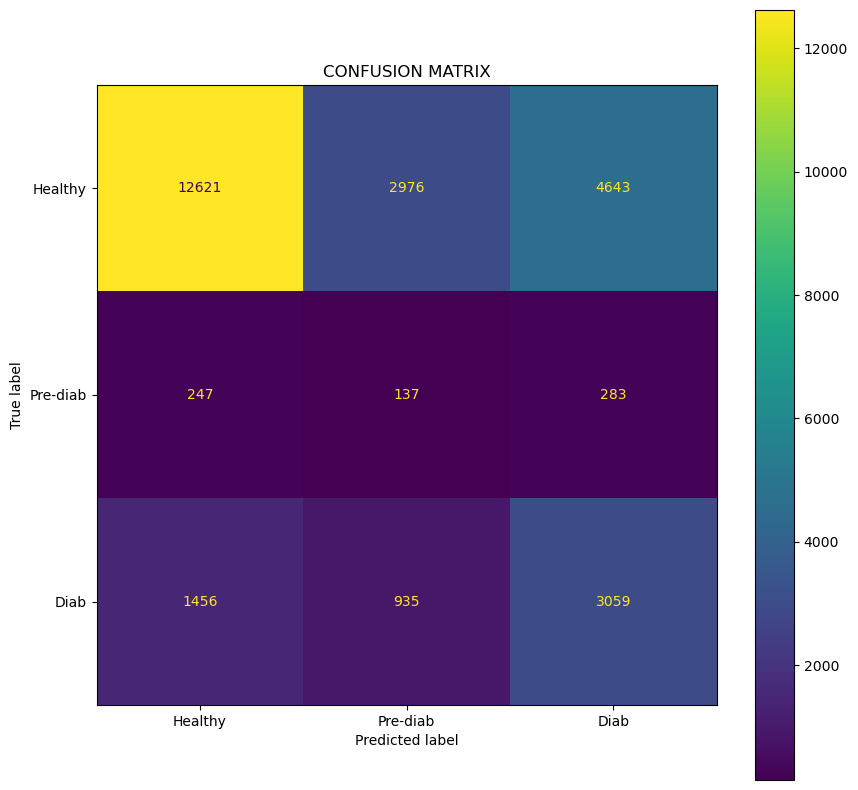

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT BalancedRandomForest:

              precision    recall  f1-score   support

     Healthy       0.88      0.54      0.67     20240
    Pre-diab       0.03      0.33      0.06       667
        Diab       0.38      0.49      0.43      5450

    accuracy                           0.52     26357
   macro avg       0.43      0.45      0.38     26357
weighted avg       0.76      0.52      0.60     26357

MCC BalancedRandomForest:  0.21112200954581264


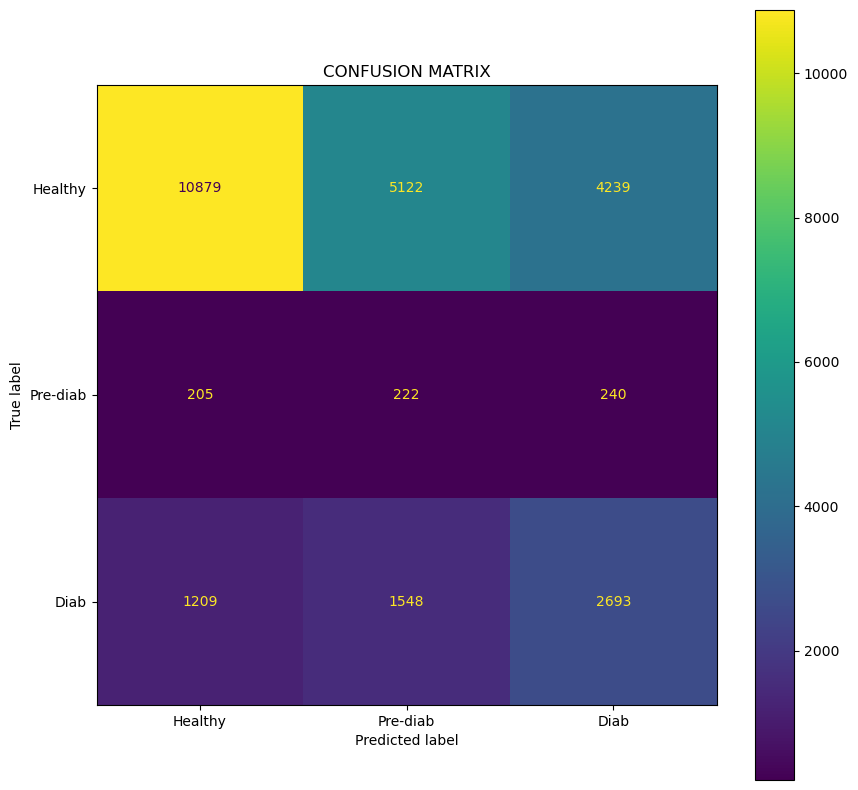

--------------------------------------------------------------------------------------------------------------------------




In [11]:
# train and predict (before threshold tuning) Lets start with the LogisticRegression dataset

# iterate on models and show confusion matrix
# create splits
x_train2 , x_test2 , y_train2 , y_test2 = train_test_split( datasets["HistogramGradientBoosting"][0] , datasets["HistogramGradientBoosting"][1],
                                                            test_size=0.2 , stratify=datasets["HistogramGradientBoosting"][1] , random_state=42)

for name , model in models.items():

    model.fit(x_train2 , y_train2)
    y_pred = model.predict(x_test2)
    
    print(f"CLASSIFICATION REPORT {name}:\n")
    print(classification_report(y_test2, y_pred, target_names=['Healthy', 'Pre-diab', 'Diab']))
    print(f"MCC {name}:  {matthews_corrcoef(y_test2 , y_pred)}")
    
    cm = confusion_matrix(y_test2, y_pred, labels=[0, 1, 2])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Pre-diab', 'Diab'])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', ax=ax, values_format='d') 
    plt.title("CONFUSION MATRIX")
    plt.show()
    
    print("--------------------------------------------------------------------------------------------------------------------------")
    print("\n")

#### Results:
Unsurprisingly, threshold tuning is required in this case also

#### 5. Threshold tuning (HistogramGradientBoosting tier 1)

In [19]:
thresholds = np.arange(0.1, 0.75, 0.05) # from 0.1 to 0.75 

for name, model in models.items():
    print(f"\n{'='*30} {name} {'='*30}")
    
    # training
    model.fit(x_train2, y_train2)
    
    # obtain probabilities
    probs_matrix = model.predict_proba(x_test2)
    prob_pre = probs_matrix[:, 1]
    prob_dia = probs_matrix[:, 2]

    print(f"{'Model ':<20} | {'THR Diab':<8} | {'THR Pre':<8} || {'REC Diab (2)':<12} | {'REC Pre (1)':<12} | {'SPEC Healthy (0)':<16}")
    print("-" * 105)

    
    #double loop to iterate over prediabetic and diabetic thresholds
    
    for t_dia in thresholds:
        for t_pre in thresholds:

            # create a 0 vector
            preds_final = np.zeros(len(y_test2))

            # prioritize diabetics
            mask_dia = prob_dia >= t_dia
            preds_final[mask_dia] = 2
            
            mask_pre = (~mask_dia) & (prob_pre >= t_pre)
            preds_final[mask_pre] = 1
            
            
            # compute metrics
            df_res = pd.DataFrame({'Real': y_test2, 'Pred': preds_final})
            
            # Recall diabetics
            rec_dia = df_res[df_res['Real'] == 2]['Pred'].apply(lambda x: 1 if x==2 else 0).mean()
            
            # Recall prediabetics
            rec_pre = df_res[df_res['Real'] == 1]['Pred'].apply(lambda x: 1 if x==1 else 0).mean()
            
            # Specifity healthy
            spec_healthy = df_res[df_res['Real'] == 0]['Pred'].apply(lambda x: 1 if x==0 else 0).mean()
            
            marker = " <---" if (rec_dia > 0.80 and rec_pre > 0.80) else ""
            
            print(f"{name:<20} | {t_dia:.2f}     | {t_pre:.2f}     || {rec_dia:.4f}       | {rec_pre:.4f}       | {spec_healthy:.4f}{marker}")

    print("-" * 105)


============================== LogisticRegression ==============================
LogisticRegression   | 0.10     | 0.10     || 0.9983       | 0.0030       | 0.0000
LogisticRegression   | 0.10     | 0.15     || 0.9983       | 0.0030       | 0.0000
LogisticRegression   | 0.10     | 0.20     || 0.9983       | 0.0030       | 0.0009
LogisticRegression   | 0.10     | 0.25     || 0.9983       | 0.0015       | 0.0035
LogisticRegression   | 0.10     | 0.30     || 0.9983       | 0.0015       | 0.0083
LogisticRegression   | 0.10     | 0.35     || 0.9983       | 0.0015       | 0.0110
LogisticRegression   | 0.10     | 0.40     || 0.9983       | 0.0000       | 0.0122
LogisticRegression   | 0.10     | 0.45     || 0.9983       | 0.0000       | 0.0126
LogisticRegression   | 0.10     | 0.50     || 0.9983       | 0.0000       | 0.0128
LogisticRegression   | 0.10     | 0.55     || 0.9983       | 0.0000       | 0.0128
LogisticRegression   | 0.10     | 0.60     || 0.9983       | 0.0000       | 0.0128
Logis

#### Results:
The possiblity of a two step classifier failed.  
Numbers tell us that to have high prediabetic recall the best strategy is to mark everyone as prediabetic.  
The problem is the data itself.  
Unsurprisingly, it is not feasable to dstinguish prediabetic, diabetic or healthy people from a questionnarie.  
But this work is not useless. 
The tier1 classifier did a decent job as a first line screening tool, and that alone can be used to at least exlude a decent portion of the population from further investigations.  

